# Neural Networks for Eddy Covarinace

In [1]:
## Import some standard packages and define a few functions
import os
# Hide default info, logs, and warnings - comment out if you need to troubleshoot
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import shutil
import importlib
import numpy as np
import pandas as pd
# from matplotlib import cm
from sklearn import metrics
import matplotlib.pyplot as plt
from Scripts import PlotHelpers
# from matplotlib.colors import Normalize
from Scripts import ReadDB, MiscFuncs, NNetFuncs

dbNames = {
    'Clean/SecondStage/TA_1_1_1':'T air',
    'Clean/SecondStage/RH_1_1_1':'RH',
    'Clean/SecondStage/FC':'FCO2',
    'Clean/SecondStage/FCH4':'FCH4',
    'Clean/SecondStage/PPFD_IN_1_1_1':'PPFD',
    'Clean/SecondStage/P_1_1_1':'Precip',
    'Flux/qc_co2_flux':'qc_FCO2',
    'Flux/qc_ch4_flux':'qc_FCH4',
    'Clean/SecondStage/USTAR':'u*',
    'Clean/SecondStage/TS_1':'T soil 5cm',
    'Clean/SecondStage/TS_2':'T soil 10cm',
    'Clean/SecondStage/TS_3':'T soil 30cm',
    'Clean/SecondStage/wind_speed':'Wind speed',
    'Clean/SecondStage/wind_dir':'Wind dir',
    'Clean/SecondStage/WTD_1_1_1':'Water table',
}

Local = '/mnt/c/Users/User/PostDoc_Work/database/'
Remote = '/mnt/w/'

Dir = Local

Site = 'BB'

read_new = True
if read_new == True:
    Data = ReadDB.get_Traces(Site,list(dbNames.keys()),Dir=Dir)
    Data = Data.rename(columns=dbNames)
    Data.to_csv(f'temp/{Site}_Data.csv')

else:
    Data = pd.read_csv(f'temp/{Site}_Data.csv',parse_dates=['TimeStamp'],index_col='TimeStamp')



## Pre-processing

In [2]:
importlib.reload(ReadDB)

Data['VPD'] = MiscFuncs.Calc_VPD(Data['T air'],Data['RH'])
Data['Water table'] = -1*(70-Data['Water table'])
Data['DOY'] = Data.index.dayofyear

target = ['FCO2','FCH4']

Data['Rand']=np.random.random(Data['FCO2'].values.shape)
Data['Rand_Bin'] = Data['Rand']-.5
Data.loc[Data['Rand_Bin']>0,'Rand_Bin']=1
Data.loc[Data['Rand_Bin']<0,'Rand_Bin']=-1
Rand_Scalars=['Rand','Rand_Bin']

print(Data[['FCO2','FCH4']].describe())
filter = ReadDB.filterFlux(Data,target)
filter.QA_QC()
filter.dir_mask('Wind dir',[[0,30],[330,360]])
filter.rain('Precip',thresh=0)
filter.MAD(z=7)
filter.uStar('u*',u_thresh=0.1)

Data[['FCO2_Clean','FCH4_Clean']] = filter.df[['FCO2','FCH4']].copy()

print(Data[['FCO2_Clean','FCH4_Clean']].describe())

excludes = ['fco2','fch4','precip']

Full_inputs = []

for val in list(Data.columns):
    exct = 0
    for ex in excludes:
        if ex in val.lower():
            exct += 1
    if exct < 1:
        Full_inputs.append(val)

Full_inputs

               FCO2          FCH4
count  33385.000000  37097.000000
mean      -0.457040     51.854595
std        3.770148     68.253487
min      -45.689865   -198.555832
25%       -1.767280      9.356360
50%       -0.121570     33.294426
75%        0.718945     89.551025
max       49.698837    695.056885
         FCO2_Clean    FCH4_Clean
count  13117.000000  11981.000000
mean      -0.945231     22.806391
std        1.620394     19.045313
min       -3.957983    -66.854370
25%       -2.261152      8.176862
50%       -0.998162     18.033709
75%        0.334959     36.511307
max        4.124954     66.968201


['T air',
 'RH',
 'PPFD',
 'u*',
 'T soil 5cm',
 'T soil 10cm',
 'T soil 30cm',
 'Wind speed',
 'Wind dir',
 'Water table',
 'VPD',
 'DOY',
 'Rand',
 'Rand_Bin']

# Make Scenarios

In [3]:
def Configure_Run(run,name,df,Base='',H=[12]):
    run['config']['Name']=name
    run['config']['Base']=Base

    # Nodes / layer = the number of inputs times a multiplier, defaults to m=5
    Nodes = [h*len(run['config']['inputs']) for h in H]
    run['config']['Nodes']=Nodes
    run['config']['Activation']=['relu' for h in H]
    run['config']['epochs']=250

    # Drop_Thresh = RI'^(Prune_scale[0])+Prune_scale[1]
    # RI' is the sum of RI for the random scalar inputs
    run['config']['Prune_scale']=[1.25,.5]
    
    run['config']['Norm']=True
    run['config']['RF_comp']=False
    run['config']['validation_split']=.2
    run['config']['patience']=2
    run['config']['N_models']=10

    run['Training'] = {}
    # run['Evaluation'] = {}

    target = Model_Runs[key]['config']['target']
    inputs = Model_Runs[key]['config']['inputs']
    Model_Runs[key]['config']['mean'] = df[inputs].mean().values
    Model_Runs[key]['config']['variance'] = df[inputs].std().values**2
    df = df.loc[df[target+inputs].dropna().index].copy()
    print(df[target+inputs].shape)
    
    Model_Runs[key]['Training']['X'] = df[inputs].values
    Model_Runs[key]['Training']['Y'] = df[target].values.flatten()

    # Larger batch > runs faster > but won't fit as well
    batch = np.ceil(Model_Runs[key]['Training']['Y'].shape[0]*.02)
    if batch<32:
        batch=32
    run['config']['batch_size']=int(batch)

    return(run)    

Model_Runs = {
    'Full_Model':{
        'config':{
            'target':['FCO2_Clean'],
            'inputs':Full_inputs,
            },
        },
}

for key in Model_Runs.keys():
    print(key)
    Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base='Test')
Model_Runs[key]['config']

Full_Model
(13087, 15)


{'target': ['FCO2_Clean'],
 'inputs': ['T air',
  'RH',
  'PPFD',
  'u*',
  'T soil 5cm',
  'T soil 10cm',
  'T soil 30cm',
  'Wind speed',
  'Wind dir',
  'Water table',
  'VPD',
  'DOY',
  'Rand',
  'Rand_Bin'],
 'Name': 'Full_Model',
 'Base': 'Test',
 'Nodes': [168],
 'Activation': ['relu'],
 'epochs': 250,
 'Prune_scale': [1.25, 0.5],
 'Norm': True,
 'RF_comp': False,
 'validation_split': 0.2,
 'patience': 2,
 'N_models': 10,
 'mean': array([ 1.06816502e+01,  8.42309494e+01,  2.21587738e+02,  1.67757392e-01,
         1.17176456e+01,  1.15721235e+01,  1.13481674e+01,  1.53174806e+00,
         1.69052139e+02, -8.71550739e-01,  2.80865645e+00,  1.83143136e+02,
         4.99832212e-01, -3.91083301e-04]),
 'variance': array([4.74444850e+01, 2.40380395e+02, 1.34442042e+05, 1.35185358e-02,
        2.75859618e+01, 2.57567701e+01, 1.30295913e+01, 1.34270860e+00,
        7.02855908e+03, 2.71025637e+02, 1.53090753e+01, 1.11195805e+04,
        8.31561820e-02, 1.00000799e+00]),
 'batch_size': 2

## Build and train model

In [4]:
importlib.reload(NNetFuncs)

Run = 'Full_Model'

def Build_Train_Eval(Run,print_sum=False):

    config = Run['config']
    Training = Run['Training']
    
    NNetFuncs.make_Dense_model(config,print_sum=print_sum)
    Eval=NNetFuncs.train_model(config,Training)
    _=NNetFuncs.run_Model(config,Eval)

Build_Train_Eval(Model_Runs[Run],print_sum=True)


Model: "Full_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 normalization (Normalizatio  (None, 14)               0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 168)               2520      
                                                                 
 dense_1 (Dense)             (None, 1)                 169       
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________
None
Training Time:
 31.0  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.88613 
RMSE =  0.55424
Run Tim

# Evaluate and prune the model

In [5]:
importlib.reload(NNetFuncs)

key='Full_Model'
Base = Model_Runs[key]['config']['Base']
Drop_Thresh_Scale = Model_Runs[key]['config']['Base']

Continue_Prune = 1
T1 = time.time()
while Continue_Prune > 0:
    RI = NNetFuncs.Prune(Base,key,Verbose=True,Prune_Scale=Model_Runs[key]['config']['Prune_scale'])
    Pruned_Inputs = list(RI.loc[RI['Drop']==0].index)
    print('Inputs: ',Pruned_Inputs,'\n\n')
    if len(Pruned_Inputs)<len(Model_Runs[key]['config']['inputs'])-len(Rand_Scalars) and len([i for i in Rand_Scalars if i in list(RI.index)]):
        key = 'Pruned_Model'
        for r in Rand_Scalars:
            if r not in Pruned_Inputs:
                Pruned_Inputs.append(r)

        Model_Runs[key]={
                'config':{
                    'target':['FCO2_Clean'],
                    'inputs':Pruned_Inputs
                    },
                }

        Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base)
        Build_Train_Eval(Model_Runs[key])
    else:
        Continue_Prune = 0
        key = 'Final_Model'
        Model_Runs[key]={
                'config':{
                    'target':['FCO2_Clean'],
                    'inputs':Pruned_Inputs
                    },
                }

        print('Final inputs: ',Model_Runs[key]['config']['inputs'])#[:-1],'\n\n')
        Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base)
        # Build_Train_Eval(Model_Runs[key],print_sum=True)
        shutil.rmtree(f'Models/{Base}/Pruned_Model')
T2 = time.time()

print("Pruning Time: ", T2-T1)

            RI_bar  RI_CI95  lower_bound  Drop
Rand          0.05     0.01         0.05  0.81
Wind dir      0.19     0.02         0.17  0.81
Rand_Bin      0.37     0.06         0.30  0.81
T air         0.49     0.08         0.41  0.81
RH            0.57     0.10         0.47  0.81
Wind speed    0.78     0.10         0.68  0.81
Inputs:  ['u*', 'VPD', 'T soil 5cm', 'Water table', 'T soil 10cm', 'DOY', 'T soil 30cm', 'PPFD'] 


(13087, 11)
Training Time:
 36.21  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.87987 
RMSE =  0.56926
Run Time:
 0.53  Seconds
10 models
Mean epochs/model:  38.9
          RI_bar  RI_CI95  lower_bound  Drop
Rand        0.07     0.01         0.06  0.82
u*          0.19     0.02         0.17  0.82
Rand_Bin    0.69     0.13         0.55  0.82
VPD         0.74     0.04         0.69  0.82
Inputs:  ['Water table', 'T soil 10cm', 'T soil 5cm', 'DOY', 'T soil 30cm', 'PPFD'] 


(13087, 9)
Training Time:
 28.74  Seconds
NN Model
 Validation metrics (ensemb

In [6]:

Model_Runs[key]['config']['N_models']*=3
Model_Runs[key]['config']['patience']=1
Build_Train_Eval(Model_Runs[key],print_sum=True)

list(RI.index)



Model: "Final_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 normalization (Normalizatio  (None, 6)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 72)                504       
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
None
Training Time:
 69.91  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.86047 
RMSE =  0.5986
Run Time:


['Rand',
 'Rand_Bin',
 'T soil 10cm',
 'Water table',
 'DOY',
 'T soil 5cm',
 'T soil 30cm',
 'PPFD']

Inspect pruned model

NN Model
 Validation metrics (ensemble mean): 
r2 =  0.85889 
RMSE =  0.60862
Run Time:
 1.97  Seconds
30 models
Mean epochs/model:  27.866666666666667
             RI_bar  RI_CI95
T soil 10cm    3.80     0.65
T soil 5cm     4.54     0.84
Water table    4.69     0.20
DOY            6.45     0.54
T soil 30cm   17.09     1.38
PPFD          63.44     1.47


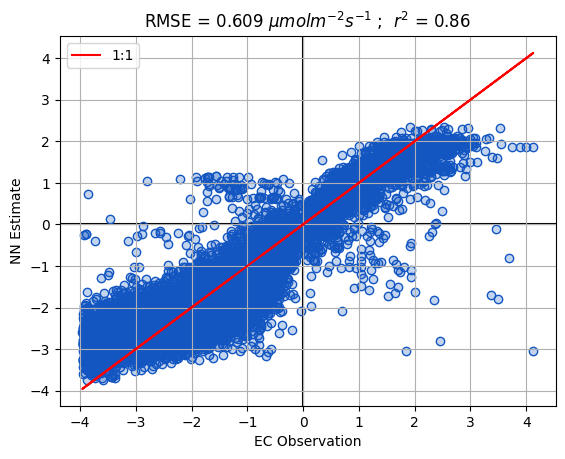

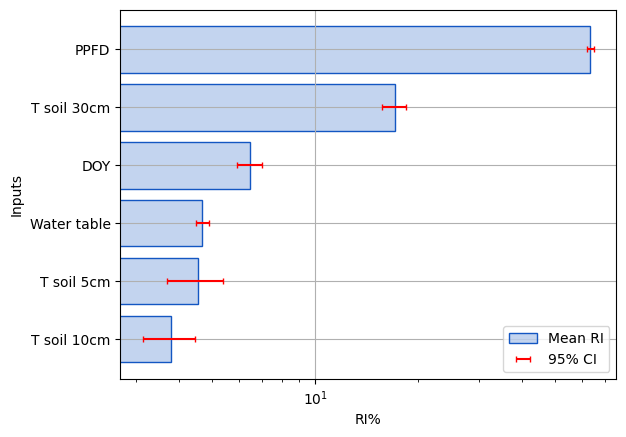

In [7]:
importlib.reload(PlotHelpers)

config = Model_Runs[key]['config']
Eval = Model_Runs[key]['Training']
full_out=NNetFuncs.run_Model(config,Eval)
# print('\n\n')

Base = Model_Runs[key]['config']['Base']
Name = Model_Runs[key]['config']['Name']


# run = 'Feature_Detection'
unit = '$\mu mol m^{-2} s^{-1}$'

df = pd.read_csv(f'Models/{Base}/{Name}/model_output.csv',index_col=[0])

fig,ax=plt.subplots()
ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
ax.set_ylabel('NN Estimate')
ax.set_xlabel('EC Observation')
 
RI = pd.read_csv(f'Models/{Base}/{Name}/model_RI.csv',index_col=[0])

RI = RI.sort_values(by=f'RI_bar',ascending=True)
fig,ax=plt.subplots()
PlotHelpers.makeRI_plot(ax,RI)

# RI['Thresh'] = RI['RI_bar']-RI['RI_CI95']
print(RI.round(2))


PPFD
T soil 30cm
Water table
T soil 5cm
T soil 10cm


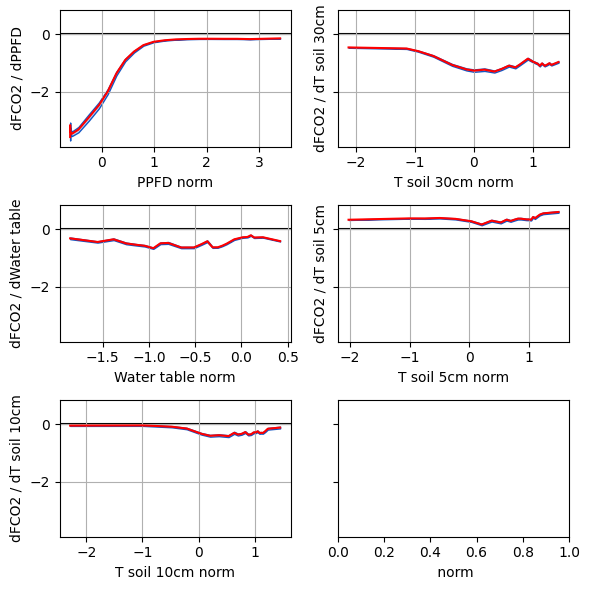

In [8]:
importlib.reload(PlotHelpers)
importlib.reload(MiscFuncs)

Max=6
Top = list(RI.sort_values(by=f'RI_bar',ascending=False).index[:Max])

exclude = ['DOY','HR']
for ex in exclude:
    try:
        Top.remove(ex)
    except:
        pass

cols = 2
npi=len(RI.index)
rows = int(np.ceil(len(Top)/2))

fig,axes=plt.subplots(rows,cols,sharey=True,
                      figsize=(6,6))

axes = axes.flatten()

mod = '_norm'

for i,xi in enumerate(Top):
    print(xi)
    # ax.axvspan(0,0,edgecolor='k',linewidth=1.5)
    df_int = MiscFuncs.byInterval(df,f'{xi}{mod}',[f'dy_d{xi}{mod}'],bins=25)
    PlotHelpers.CI_Plot(axes[i],df_int,f'dy_d{xi}{mod}')
plt.tight_layout()

axes[i].get_ylabel()

for ax in axes:
    l = ax.get_ylabel().split('_norm')[0]
    ax.set_ylabel(l.replace('_',' / ').replace('y','FCO2'))
    ax.set_xlabel(l.split('_d')[-1]+' '+mod.split('_')[-1])
    plt.tight_layout()


In [9]:

# df = pd.read_csv(f'Models/{run}/random_forest_output.csv',index_col=[0])

# unit = ''

# fig,ax=plt.subplots()
# ax.scatter(df['target'],df['y_bar'])
# ax.plot(df['target'],df['target'],color='k')
# r2 = np.round(metrics.r2_score(df['target'],df['y_bar']),2)
# RMSE = np.round(metrics.mean_squared_error(df['target'],df['y_bar'])**.5,2)
# ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
# ax.set_ylabel('NN Estimate')
# ax.set_xlabel('EC Observation')

# RF_RI = pd.read_csv(f'Models/{run}/random_forest_RI.csv',index_col=[0])

# mod = ''

# RF_RI = RF_RI.sort_values(by = f'RI{mod}_bar')

# fig,ax=plt.subplots()
# ax.barh(RF_RI.index,RF_RI[f'RI{mod}_bar'],xerr=RF_RI[f'RI{mod}_CI95'])
# ax.grid()
# ax.set_xscale('log')

# RF_RI

In [10]:
# NN_RI = pd.read_csv(f'{run}/model_RI.csv',index_col=[0])
# mod = '_norm'

# NN_RI = NN_RI.sort_values(by=f'RI{mod}_bar',ascending=True)
# fig,ax=plt.subplots()

# ax.barh(NN_RI.index,NN_RI[f'RI{mod}_bar'],yerr=NN_RI[f'RI{mod}_CI95'])
# ax.grid()


In [11]:
# RF_Output = pd.read_csv(f'{run}/random_forest_output.csv',index_col=[0])

# RF_Output.head()